# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [1]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from scipy import stats
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [3]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [4]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\Bjorn\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [5]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [6]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

In [7]:
X_test
# Kjører denne for å sjekke hvilket kjønn er 0 og hvilket er 1

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1142,31,0,852,0,25,2,3,1,4,1,...,4,80,0,10,3,4,10,9,4,8
1044,42,0,1117,0,24,4,3,1,3,1,...,1,80,1,6,3,3,6,3,0,4
1000,29,1,490,0,29,3,3,1,4,1,...,4,80,0,11,2,3,11,10,1,9
1121,30,1,1480,0,27,4,1,1,3,0,...,3,80,1,4,4,3,3,2,1,2
1212,49,1,989,0,6,3,0,1,4,0,...,1,80,1,23,2,3,8,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,48,1,1324,0,25,3,3,1,3,0,...,3,80,3,20,2,3,2,2,2,2
1487,19,2,544,0,5,3,3,1,4,1,...,1,80,0,1,3,4,1,0,0,0
218,45,1,918,1,2,4,2,1,1,1,...,4,80,1,12,4,3,6,2,0,4
1333,35,1,1125,1,5,4,0,1,3,1,...,1,80,1,6,5,4,3,2,0,2


#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

In [8]:
#TODO: visualiser y_train og y_test i et histogram

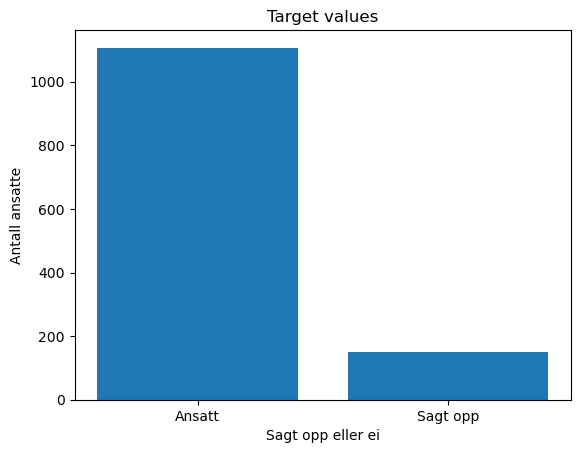

<Figure size 500x500 with 0 Axes>

In [9]:
plt.title("Target values")
plt.bar(x=np.unique(y_train, return_counts=True)[0], height= np.unique(y_train, return_counts=True)[1])
plt.xticks([0,1],["Ansatt", "Sagt opp"])
plt.xlabel("Sagt opp eller ei")
plt.ylabel("Antall ansatte")
plt.figure(figsize=(5,5))
plt.show() 

# Det står histogram men føler en barplot illustrerer klassifiseringen bedre. 
# Her er histogram kodenbiten :
# plt.hist(y_train, density=True, color="C1", label="train")
# plt.hist(y_test, density=True, color="C0", alpha=0.5, label="test")



**Svar:**

*Y verdiene er diskrete tall og dette tyder på at vi skal se på en klassifiseringsoppgave.*

<span style='color:red '> Korrekt! Target er en diskret og binær variabel og derfor er det er klassifiseringsproblem. Veldig bra at du har lagt til etiketter på aksene i figuren. </span>

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


*Jeg velger å bruke default parametre*

In [11]:
# Velg to modeller og gjøre repeterte kryssvalideringer (10) med K = 5
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)

# Modell 1. Logistisk regresjon
f1_score_log_reg = []
nøyaktighet_scores_log_reg = []

for i, (train_index, val_index) in enumerate(rkf.split(X_train)):
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    logreg = LogisticRegression(solver='lbfgs',max_iter=10000)
    logreg.fit(X_train_cv, y_train_cv)
    
    y_val_hat = logreg.predict_proba(X_val_cv)[:,1]
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)
    f1_score_log_reg.append(score)
    
    nøyaktighet = accuracy_score(y_val_cv, (y_val_hat > 0.5).astype(int)) 
    # y_val_hat > 0.5 as integer er viktig for å kunne velge enten positiv eller negativ class
    nøyaktighet_scores_log_reg.append(nøyaktighet)
    
log_reg_mean = np.asarray(f1_score_log_reg).mean().round(3)
log_reg_std = np.asarray(f1_score_log_reg).std().round(3)
mean_nøyaktighet_score = np.mean(nøyaktighet_scores_log_reg)
print(r"Mean F1 Score (Logistic Regresssion) = {} ± standardavvik {}".format(log_reg_mean,log_reg_std))
print("Mean nøyaktighets score (Logistic Regression) = ", mean_nøyaktighet_score.round(3))

Mean F1 Score (Logistic Regresssion) = 0.272 ± standardavvik 0.089
Mean nøyaktighets score (Logistic Regression) =  0.884


*Logg: Prøvde MLP men fikk mer fornuftig resultat ved å kjøre en SVC classifier. Mulig at jeg burde tweeket MLPClassifier innstillingene*

In [12]:
# Modell 2. Support Vector Machines (SVM)
# Opprettet en scaler
scaler = StandardScaler()
f1_scores_svm = []
nøyaktighet_scores_svm = []

# Dataen vår i X_train er bruker varierende skala. 
# Noen verdier er binære, alder streker seg mellom 18 og 60 f.eks, inntekt er målt i tusenvis.
# Ved å skalere kan man unngå at avstanden mellom "data points" får like mye vekt.
# Med andre ord, man unngår/minimiserer bias i ML læreprosessen.

svm = SVC(kernel='rbf', C=1, random_state=0) # bruker standard parametere funnet i scikit-learn

for i, (train_index, val_index) in enumerate(rkf.split(X_train)):
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    X_train_cv_scaled = scaler.fit_transform(X_train_cv)
    X_val_cv_scaled = scaler.transform(X_val_cv)

    svm.fit(X_train_cv_scaled, y_train_cv)

    y_val_hat = svm.predict(X_val_cv_scaled)

    f1 = f1_score(y_val_cv, y_val_hat, average='binary')
    # Her trenger vi ikke "y_val_hat > 0.5 as integer" fordi SVM er "by design" binary classifier
    f1_scores_svm.append(f1)
    
    nøyaktighet = accuracy_score(y_val_cv, y_val_hat)
    nøyaktighet_scores_svm.append(nøyaktighet)

mean_f1_score_svm = np.asarray(f1_scores_svm).mean().round(3)
svm_std = np.asarray(f1_scores_svm).std().round(3)
mean_nøyaktighet_score = np.mean(nøyaktighet_scores_svm)
print(r"Mean F1 Score (SVM) = {} ± standardavvik {}".format(mean_f1_score_svm,svm_std))
print("Mean nøyaktighets score (SVM) = ", mean_nøyaktighet_score.round(3))

Mean F1 Score (SVM) = 0.03 ± standardavvik 0.044
Mean nøyaktighets score (SVM) =  0.882


In [13]:
# Det viser seg at man får mye bedre f1 score om man finner de beste hyperparametrene

best_params_list = []
best_score_list = []

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
    
for train_index, val_index in rkf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    X_train_cv_scaled = scaler.fit_transform(X_train_cv)
    X_val_cv_scaled = scaler.transform(X_val_cv)

    svm = SVC(random_state=0)

    grid_search = GridSearchCV(svm, param_grid, cv=rkf, scoring='f1', n_jobs=-1)

    grid_search.fit(X_train_cv_scaled, y_train_cv)

    best_params = grid_search.best_params_
    best_svm = grid_search.best_estimator_

    y_val_hat = best_svm.predict(X_val_cv_scaled)

    f1 = f1_score(y_val_cv, y_val_hat, average='binary')

    best_params_list.append(best_params)
    best_score_list.append(f1)

mean_f1_score_svm = np.mean(best_score_list).round(3)

# Få den beste parameterkombinasjonen og scoren
best_params = best_params_list[np.argmax(best_score_list)]
best_score = max(best_score_list)


# Skriv ut resultatet
print("Beste parameterkombinasjon:", best_params)
print("Beste score (f1):", best_score)

Beste parameterkombinasjon: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Beste score (f1): 0.5283018867924528


*Beste parameterkombinasjon: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}*

*Beste score (neg_mean_squared_error): 0.5283018867924528*

In [14]:
# Tester CVM igjen etter at hyperparametrene er funnet
# Modell 2. Support Vector Machines (SVM)
# Opprettet en scaler
scaler = StandardScaler()
f1_scores_svm = []
nøyaktighet_scores_svm = []

# Dataen vår i X_train er bruker varierende skala. 
# Noen verdier er binære, alder streker seg mellom 18 og 60 f.eks, inntekt er målt i tusenvis.
# Ved å skalere kan man unngå at avstanden mellom "data points" får like mye vekt.
# Med andre ord, man unngår/minimiserer bias i ML læreprosessen.

svm = SVC(kernel='rbf', gamma = "auto", C=10, random_state=0) 

for i, (train_index, val_index) in enumerate(rkf.split(X_train)):
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    X_train_cv_scaled = scaler.fit_transform(X_train_cv)
    X_val_cv_scaled = scaler.transform(X_val_cv)

    svm.fit(X_train_cv_scaled, y_train_cv)

    y_val_hat = svm.predict(X_val_cv_scaled)

    f1 = f1_score(y_val_cv, y_val_hat, average='binary')
    # Her trenger vi ikke "y_val_hat > 0.5 as integer" fordi SVM er "by design" binary classifier
    f1_scores_svm.append(f1)
    
    nøyaktighet = accuracy_score(y_val_cv, y_val_hat)
    nøyaktighet_scores_svm.append(nøyaktighet)

mean_f1_score_svm = np.asarray(f1_scores_svm).mean().round(3)
svm_std = np.asarray(f1_scores_svm).std().round(3)
mean_nøyaktighet_score = np.mean(nøyaktighet_scores_svm)
print(r"Mean F1 Score (SVM) = {} ± standardavvik {}".format(mean_f1_score_svm,svm_std))
print("Mean nøyaktighets score (SVM) = ", mean_nøyaktighet_score.round(3))

Mean F1 Score (SVM) = 0.338 ± standardavvik 0.082
Mean nøyaktighets score (SVM) =  0.874


**Observasjoner:**

  *Logistisk Regresjon*    
 - Mean F1 Score (Logistic Regresssion) = 0.279 ± standardavvik 0.093
 - Mean nøyaktighets score (Logistic Regression) =  0.884
 
 *SVM*
 
 - Mean F1 Score (SVM) = 0.338 ± standardavvik 0.082
 - Mean nøyaktighets score (SVM) =  0.874


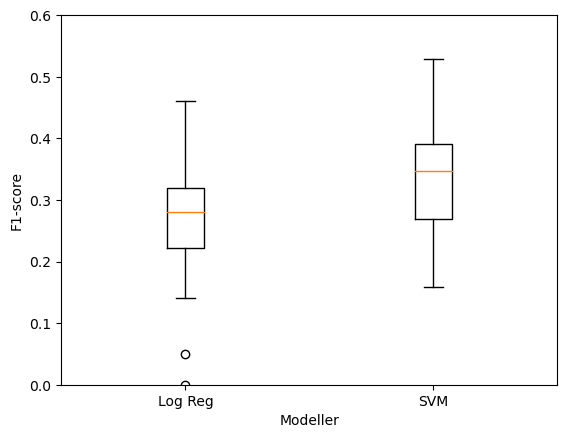

In [15]:
# Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
plt.boxplot([np.asarray(f1_score_log_reg),np.asarray(f1_scores_svm)])
plt.ylim(0,0.6)
plt.xticks([1,2],["Log Reg","SVM"])
plt.ylabel("F1-score")
plt.xlabel("Modeller")
plt.show()

In [16]:
# Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test 
# på F1-skårene fra de repeterte kryssvalideringene

t_stat, p_value = stats.ttest_ind(np.asarray(f1_score_log_reg),np.asarray(f1_scores_svm), axis=0, equal_var=True, alternative="two-sided")

p_verdi = round(p_value, 7)

print("p-verdi =", p_verdi)

p-verdi = 0.0002459


*"Det er signifikansnivået en p -verdi sammenlignes med når man skal avgjøre om noe er statistisk signifikant." - kilde: https://snl.no/signifikansnivå*

*La oss anta en signifikansnivå alpha = 0.05*

*Vår p-verdi 0.0011103 er mye lavere enn 0.5 og dette kan tyde på at f1 skårene til de 2 testene er statistisk forskjellige. Med andre ord, forskjellene i f1 scårene kan ikke forklares med tilfeldighet"


<span style='color:red '> Dette er meget bra! Interessant at du har fått så bra resultat med SVM. Savner en setning som sier hvem av modellene som er best i følge T-testen, men regner med at du ser at dette er SVM-modellen   </span>

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

SMOTE : genererer syntetiske eksempler basert på minoritets-eksempler.
Formålet er å forbedre ytelsen til ML modeller når man har noen "tyngre" klasser.
Som navnet tilsier det : SMOTE "smoother" over bias.

SMOTE = Synthetic Minority Over-sampling Technique

In [17]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=0)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Modell 1. Logistisk regresjon
f1_score_log_reg = []
nøyaktighet_scores_log_reg = []

for i, (train_index, val_index) in enumerate(rkf.split(X_train_resampled)):
    
    X_train_cv, X_val_cv = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    y_train_cv, y_val_cv = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
    
    logreg = LogisticRegression(solver='lbfgs',max_iter=10000)
    logreg.fit(X_train_cv, y_train_cv)
    
    y_val_hat = logreg.predict_proba(X_val_cv)[:,1]
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)
    f1_score_log_reg.append(score)
    
    nøyaktighet = accuracy_score(y_val_cv, (y_val_hat > 0.5).astype(int)) 
    nøyaktighet_scores_log_reg.append(nøyaktighet)
    
log_reg_mean = np.asarray(f1_score_log_reg).mean().round(3)
log_reg_std = np.asarray(f1_score_log_reg).std().round(3)
mean_nøyaktighet_score = np.mean(nøyaktighet_scores_log_reg)
print(r"Mean F1 Score (Logistic Regresssion) = {} ± standardavvik {}".format(log_reg_mean,log_reg_std))
print("Mean nøyaktighets score (Logistic Regression) = ", mean_nøyaktighet_score.round(3))

Mean F1 Score (Logistic Regresssion) = 0.887 ± standardavvik 0.014
Mean nøyaktighets score (Logistic Regression) =  0.888


In [18]:
# Modell 2. Support Vector Machines (SVM)
scaler = StandardScaler()
f1_scores_svm = []
nøyaktighet_scores_svm = []
svm = SVC(kernel='rbf', gamma = "auto", C=10, random_state=0) 

smote = SMOTE(sampling_strategy='auto', random_state=0)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

for i, (train_index, val_index) in enumerate(rkf.split(X_train_resampled)):
    
    X_train_cv, X_val_cv = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    y_train_cv, y_val_cv = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
    
    X_train_cv_scaled = scaler.fit_transform(X_train_cv)
    X_val_cv_scaled = scaler.transform(X_val_cv)

    svm.fit(X_train_cv_scaled, y_train_cv)

    y_val_hat = svm.predict(X_val_cv_scaled)

    f1 = f1_score(y_val_cv, y_val_hat, average='binary')
    f1_scores_svm.append(f1)
    
    nøyaktighet = accuracy_score(y_val_cv, y_val_hat)
    nøyaktighet_scores_svm.append(nøyaktighet)

mean_f1_score_svm = np.asarray(f1_scores_svm).mean().round(3)
svm_std = np.asarray(f1_scores_svm).std().round(3)
mean_nøyaktighet_score = np.mean(nøyaktighet_scores_svm)
print(r"Mean F1 Score (SVM) = {} ± standardavvik {}".format(mean_f1_score_svm,svm_std))
print("Mean nøyaktighets score (SVM) = ", mean_nøyaktighet_score.round(3))

Mean F1 Score (SVM) = 0.946 ± standardavvik 0.01
Mean nøyaktighets score (SVM) =  0.945


**Svar:**

**Valideringsdataene:**

  *Logistisk Regresjon*    
 - Mean F1 Score (Logistic Regresssion) = 0.279 ± standardavvik 0.093
 - Mean nøyaktighets score (Logistic Regression) =  0.884
 
 *SVM*
 
 - Mean F1 Score (SVM) = 0.338 ± standardavvik 0.082
 - Mean nøyaktighets score (SVM) =  0.874

**Oppsamplingsdataene**

*LogReg - resampled*
 - Mean F1 Score (Logistic Regresssion) = 0.887 ± standardavvik 0.014
 - Mean nøyaktighets score (Logistic Regression) =  0.888
 
*SVM - resampled*
 - Mean F1 Score (SVM) = 0.946 ± standardavvik 0.01
 - Mean nøyaktighets score (SVM) =  0.945
 
**Det er tydelig er man får mye bedre (3-4 ganger) f1 skårer når man tester på den oppsamplede (SMOTE) treningsdataen.**

*Viktig å merke at standardavviket ved begge modellene er betydelige redusert.*

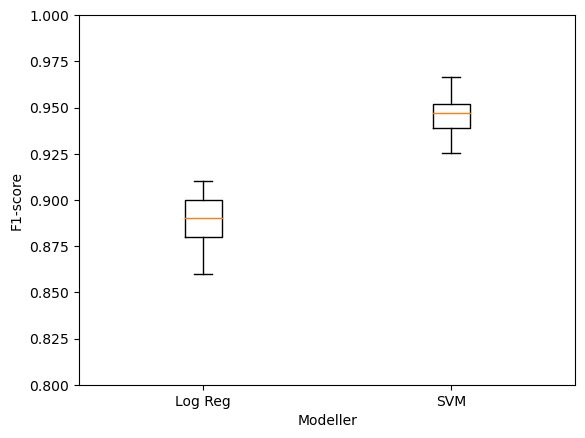

In [19]:
# Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
plt.boxplot([np.asarray(f1_score_log_reg),np.asarray(f1_scores_svm)])
plt.ylim(0.8,1)
plt.xticks([1,2],["Log Reg","SVM"])
plt.ylabel("F1-score")
plt.xlabel("Modeller")
plt.show()

In [20]:
# Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene

t_stat, p_value = stats.ttest_ind(np.asarray(f1_score_log_reg),np.asarray(f1_scores_svm), axis=0, equal_var=True, alternative="two-sided")

p_verdi = round(p_value, 7)

print("p-verdi =", p_verdi)

p-verdi = 0.0


**P-verdi**

*Denne gangen er p-verdien 0.0 og dette indikerer ekstremt stor forskjell mellom f1 skårene etter at modellene ble trent på den oppsamplede dataen.*


<span style='color:red '> Mye bra, men du går i en liten felle som jeg prøvde å hjelpe dere med å unngå i første punktet av beskrivelsen av oppgaven - "bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene" </span>

<span style='color:red '>Å oppsample med SMOTE, basert på hele datasettet og deretter dele det oppsamplede i trening og validering kan føre til datalekkasje fordi de oppsamplede treningsdataene har elementer av valideringsdataene i seg. Dette gjør seg helt klart gjeldene i dette eksemplet. </span>

<span style='color:red '> I eksemplet nedenfor viser jeg en annen løsning der datalekkasje unngås </span>

<span style='color:red '> I SVM-delen har du glemt å definere SVM modellen inne i for-loopen som du har gjort for logreg </span>

In [24]:
#rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

f1_score_lr_SMOTE = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train, y_train)):    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    smote = SMOTE(random_state=0)
    X_train_balanced_cv, y_train_balanced_cv = smote.fit_resample(X_train_cv, y_train_cv)
    
    
    logreg = LogisticRegression(solver='lbfgs',max_iter=10000).fit(X_train_balanced_cv,y_train_balanced_cv)
    y_val_hat = logreg.predict_proba(X_val_cv)[:,1]
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)
    f1_score_lr_SMOTE.append(score)
f1_score_lr_SMOTE = np.asarray(f1_score_lr_SMOTE)

In [25]:
print("gjenommsnittlig F1-skår = {}, standardavvik = {}".format(f1_score_lr_SMOTE.mean().round(4),f1_score_lr_SMOTE.std().round(4)))

gjenommsnittlig F1-skår = 0.4216, standardavvik = 0.0782


#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [26]:
# TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene
# Den beste modellen fra 2.2 og 2.3 viser seg å være "SVM-sampled" pga både høyest f1 score og nøyaktighet.

In [27]:
# Modell 2. Support Vector Machines (SVM)
# Med SMOTE-ing
scaler = StandardScaler()
svm = SVC(kernel='rbf', gamma = "auto", C=10, random_state=0) 
# Sampling av treningssettet
smote = SMOTE(sampling_strategy='auto', random_state=0)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Skalering av X verdiene for utjevning
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Trening på alle treningsdataene
svm.fit(X_train_scaled, y_train_resampled)

# Test på testdataene
y_test_hat = svm.predict(X_test_scaled)

# Beregning av ytelsen og utskrift av metrikkene
print("F1-score = ",f1_score(y_test,(y_test_hat>0.5)*1,average='binary').round(3))
print("Nøyaktighet = ",accuracy_score(y_test,(y_test_hat>0.5)*1).round(3))
print("Sensitivitet = ",recall_score(y_test,(y_test_hat>0.5)*1,pos_label=1).round(3))
print("Spesifisitet = ",recall_score(y_test,(y_test_hat>0.5)*1,pos_label=0).round(3))
print("Presisjon = ",precision_score(y_test,(y_test_hat>0.5)*1).round(3))

F1-score =  0.25
Nøyaktighet =  0.843
Sensitivitet =  0.22
Spesifisitet =  0.927
Presisjon =  0.289


In [28]:
# Modell 2. Support Vector Machines (SVM)
# Uten SMOTE-ing
scaler = StandardScaler()
svm = SVC(kernel='rbf', gamma = "auto", C=10, random_state=0) 
# Sampling av treningssettet

# Skalering av X verdiene for utjevning
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Trening på alle treningsdataene
svm.fit(X_train_scaled, y_train)

# Test på testdataene
y_test_hat = svm.predict(X_test_scaled)

# Beregning av ytelsen og utskrift av metrikkene
print("F1-score = ",f1_score(y_test,(y_test_hat>0.5)*1,average='binary').round(3))
print("Nøyaktighet = ",accuracy_score(y_test,(y_test_hat>0.5)*1).round(3))
print("Sensitivitet = ",recall_score(y_test,(y_test_hat>0.5)*1,pos_label=1).round(3))
print("Spesifisitet = ",recall_score(y_test,(y_test_hat>0.5)*1,pos_label=0).round(3))
print("Presisjon = ",precision_score(y_test,(y_test_hat>0.5)*1).round(3))

F1-score =  0.222
Nøyaktighet =  0.85
Sensitivitet =  0.18
Spesifisitet =  0.941
Presisjon =  0.29


**Observasjon**

Med SMOTE-ing:
F1-score =  0.25
Nøyaktighet =  0.843
Sensitivitet =  0.22
Spesifisitet =  0.927
Presisjon =  0.289

Uten SMOTE-ting:
F1-score =  0.222
Nøyaktighet =  0.85
Sensitivitet =  0.18
Spesifisitet =  0.941
Presisjon =  0.29

Under predikering på treningssettet med oppsamlet minoritetsklasse fikk man 3 ganger høyere f1 score enn når man ikke oppsamplet minoritetsklassen.

Men når man predikerer på test-settet er forskjellen i f1 og nøyaktighet nesten ubetydelig:
f1 (0.25 og 0.222)
nøyaktighet (0.843 og 0.85)

<span style='color:red '> Her gjør du alt rett, men du blir selvsagt litt forvirret fordi man skulle forventet bedre resultater basert på resultatene i forrige oppgave der vi opplevde en datalekkasje </span>

#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [31]:
X_test

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1142,31,0,852,0,25,2,3,1,4,1,...,4,80,0,10,3,4,10,9,4,8
1044,42,0,1117,0,24,4,3,1,3,1,...,1,80,1,6,3,3,6,3,0,4
1000,29,1,490,0,29,3,3,1,4,1,...,4,80,0,11,2,3,11,10,1,9
1121,30,1,1480,0,27,4,1,1,3,0,...,3,80,1,4,4,3,3,2,1,2
1212,49,1,989,0,6,3,0,1,4,0,...,1,80,1,23,2,3,8,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,48,1,1324,0,25,3,3,1,3,0,...,3,80,3,20,2,3,2,2,2,2
1487,19,2,544,0,5,3,3,1,4,1,...,1,80,0,1,3,4,1,0,0,0
218,45,1,918,1,2,4,2,1,1,1,...,4,80,1,12,4,3,6,2,0,4
1333,35,1,1125,1,5,4,0,1,3,1,...,1,80,1,6,5,4,3,2,0,2


In [32]:
# Bruker mapping for endre kjønnsmappingen tilbake til kategorisk data
gender_mapping = {0: 'Male', 1: 'Female'}
X_test['Gender'] = X_test['Gender'].map(gender_mapping)
X_test

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1142,31,0,852,0,25,2,3,1,4,Female,...,4,80,0,10,3,4,10,9,4,8
1044,42,0,1117,0,24,4,3,1,3,Female,...,1,80,1,6,3,3,6,3,0,4
1000,29,1,490,0,29,3,3,1,4,Female,...,4,80,0,11,2,3,11,10,1,9
1121,30,1,1480,0,27,4,1,1,3,Male,...,3,80,1,4,4,3,3,2,1,2
1212,49,1,989,0,6,3,0,1,4,Male,...,1,80,1,23,2,3,8,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,48,1,1324,0,25,3,3,1,3,Male,...,3,80,3,20,2,3,2,2,2,2
1487,19,2,544,0,5,3,3,1,4,Female,...,1,80,0,1,3,4,1,0,0,0
218,45,1,918,1,2,4,2,1,1,Female,...,4,80,1,12,4,3,6,2,0,4
1333,35,1,1125,1,5,4,0,1,3,Female,...,1,80,1,6,5,4,3,2,0,2


In [35]:
# TODO: Gjør kjønnsbasert analyse på testdataene
# Bruk følgende for å splitte datasettet i 2 testsett (menn og kvinner) 

X_test_female = X_test[X_test['Gender'] == 'Female']
y_test_female = y_test[X_test['Gender'] == 'Female']
X_test_male = X_test[X_test['Gender'] == 'Male']
y_test_male = y_test[X_test['Gender'] == 'Male']

X_test_male # sjekker 

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1121,30,1,1480,0,27,4,1,1,3,Male,...,3,80,1,4,4,3,3,2,1,2
1212,49,1,989,0,6,3,0,1,4,Male,...,1,80,1,23,2,3,8,7,7,7
725,49,1,1223,0,1,3,3,1,2,Male,...,3,80,0,8,2,4,8,6,0,7
438,36,2,1179,0,15,3,0,1,3,Male,...,2,80,0,10,3,3,5,4,0,3
716,25,2,1480,0,1,4,0,1,4,Male,...,2,80,1,6,2,2,6,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,35,1,562,0,1,2,0,1,3,Male,...,3,80,0,10,3,4,10,8,3,7
771,44,1,587,0,21,2,3,1,3,Male,...,4,80,1,10,3,3,10,8,0,8
1515,48,2,1402,0,25,3,3,1,3,Male,...,3,80,0,25,3,3,1,0,0,0
224,26,1,959,0,5,3,3,1,1,Male,...,3,80,0,8,2,1,8,7,0,7


In [38]:
# Etter å ha splittet testsettet i to kjønn, endrer vi til numerisk data i Gender kolonne. 
# Grunnen til dette er for å kunne regne på disse
gender_mapping_male = {'Male': 0}
X_test_male_2 = X_test_male.copy() # Dette her var viktig for å ikke få NaN
X_test_male_2['Gender'] = X_test_male_2['Gender'].map(gender_mapping_male)
X_test_male_2['Gender'] = pd.to_numeric(X_test_male_2['Gender'])
X_test_male_2

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1121,30,1,1480,0,27,4,1,1,3,0,...,3,80,1,4,4,3,3,2,1,2
1212,49,1,989,0,6,3,0,1,4,0,...,1,80,1,23,2,3,8,7,7,7
725,49,1,1223,0,1,3,3,1,2,0,...,3,80,0,8,2,4,8,6,0,7
438,36,2,1179,0,15,3,0,1,3,0,...,2,80,0,10,3,3,5,4,0,3
716,25,2,1480,0,1,4,0,1,4,0,...,2,80,1,6,2,2,6,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,35,1,562,0,1,2,0,1,3,0,...,3,80,0,10,3,4,10,8,3,7
771,44,1,587,0,21,2,3,1,3,0,...,4,80,1,10,3,3,10,8,0,8
1515,48,2,1402,0,25,3,3,1,3,0,...,3,80,0,25,3,3,1,0,0,0
224,26,1,959,0,5,3,3,1,1,0,...,3,80,0,8,2,1,8,7,0,7


In [39]:
# Vi utfører det samme for kvinner
gender_mapping_female = {'Female': 1}
X_test_female_2 = X_test_female.copy() # Dette her var viktig for å ikke få NaN
X_test_female_2['Gender'] = X_test_female_2['Gender'].map(gender_mapping_female)
X_test_female_2['Gender'] = pd.to_numeric(X_test_female_2['Gender'])
X_test_female_2

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1142,31,0,852,0,25,2,3,1,4,1,...,4,80,0,10,3,4,10,9,4,8
1044,42,0,1117,0,24,4,3,1,3,1,...,1,80,1,6,3,3,6,3,0,4
1000,29,1,490,0,29,3,3,1,4,1,...,4,80,0,11,2,3,11,10,1,9
271,53,2,945,0,6,4,0,1,2,1,...,1,80,2,32,2,2,4,3,1,2
414,53,1,1479,1,7,4,2,1,3,1,...,2,80,0,26,3,3,14,10,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,27,0,573,0,9,4,0,1,3,1,...,4,80,0,7,2,3,7,7,0,5
1487,19,2,544,0,5,3,3,1,4,1,...,1,80,0,1,3,4,1,0,0,0
218,45,1,918,1,2,4,2,1,1,1,...,4,80,1,12,4,3,6,2,0,4
1333,35,1,1125,1,5,4,0,1,3,1,...,1,80,1,6,5,4,3,2,0,2


In [40]:
# Menn. Support Vector Machines (SVM) med SMOTE-ing
scaler = StandardScaler()
svm = SVC(kernel='rbf', gamma = "auto", C=10, random_state=0) 
smote = SMOTE(sampling_strategy='auto', random_state=0)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_male_2) # endrer til X_test til X_test_male_2
svm.fit(X_train_scaled, y_train_resampled)
y_test_hat = svm.predict(X_test_scaled)
# Nedenfor endrer jeg også til _male versjonen av testsettet
print("Menn")
print("F1-score = ",f1_score(y_test_male,(y_test_hat>0.5)*1,average='binary').round(3))
print("Nøyaktighet = ",accuracy_score(y_test_male,(y_test_hat>0.5)*1).round(3))
print("Sensitivitet = ",recall_score(y_test_male,(y_test_hat>0.5)*1,pos_label=1).round(3))
print("Spesifisitet = ",recall_score(y_test_male,(y_test_hat>0.5)*1,pos_label=0).round(3))
print("Presisjon = ",precision_score(y_test_male,(y_test_hat>0.5)*1).round(3))

# Kvinner. Support Vector Machines (SVM) med SMOTE-ing
scaler = StandardScaler()
svm = SVC(kernel='rbf', gamma = "auto", C=10, random_state=0) 
smote = SMOTE(sampling_strategy='auto', random_state=0)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_female_2) # endrer til X_test til X_test_female_2
svm.fit(X_train_scaled, y_train_resampled)
y_test_hat = svm.predict(X_test_scaled)
# Nedenfor endrer jeg også til _male versjonen av testsettet
print("\nKvinner")
print("F1-score = ",f1_score(y_test_female,(y_test_hat>0.5)*1,average='binary').round(3))
print("Nøyaktighet = ",accuracy_score(y_test_female,(y_test_hat>0.5)*1).round(3))
print("Sensitivitet = ",recall_score(y_test_female,(y_test_hat>0.5)*1,pos_label=1).round(3))
print("Spesifisitet = ",recall_score(y_test_female,(y_test_hat>0.5)*1,pos_label=0).round(3))
print("Presisjon = ",precision_score(y_test_female,(y_test_hat>0.5)*1).round(3))

Menn
F1-score =  0.281
Nøyaktighet =  0.818
Sensitivitet =  0.25
Spesifisitet =  0.912
Presisjon =  0.321

Kvinner
F1-score =  0.167
Nøyaktighet =  0.88
Sensitivitet =  0.143
Spesifisitet =  0.948
Presisjon =  0.2


*For menn er f1, sensitivitet og presisjon høyere og dette indikerer at modellen yter bedre for datasettet med menn.*

*Årsaksanalyse: En mulig forklaring kan være at modellen inneholder større og mer variert data for menn.*

*Forbedring: En kunne prøvd å få inn mer data for kvinner slik at dataen balanseres og man resuderer bias. Dessuten kunne man prøvd andre modeller enn Logistisk Regresjon og SVM*

<span style='color:red '> Helt riktig. Her er det en ubalanse i antall menn og kvinner i datasettet og dette ender ofte opp i en urettferdig modell, som får dårligere sensitivitet ovenfor kjønnet med færrest eksempler. Det finnes flere måter å balansere dette på, blant annet å samle mer data fra kvinner. Noen andre eksempler er å 1) fjerne data fra datasettet slik at det blir lik fordeling mellom begge kjønnene. ulempen med dette er man potensielt lager en dårligere modell for å skape rettferdighet. 2) En annen mulighet er å oppsample dataene fra kjønnet med færrest eksempler. 3) For modeller trent med SGD kan man ofte vekte noen eksepler høyere enn andre i treningsprosessen. 4) lage en modell for hvert kjønn. Det finnes ingen fasitsvar på hva som er best her, så dette må testes empirisk.
  
</span>

Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [ ]:
#!pip freeze > requirements.txt